<a href="https://colab.research.google.com/github/PhilipPfeffer/haptic_vest/blob/main/data_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Data

In [ ]:
from pycocotools.coco import COCO     # https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocotools/coco.py
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
# import pylab


In [ ]:
rel_path='..'
datasetName='val2017'
annotations=f'/content/drive/My Drive/Haptic Vest/coco_dataset/annotations/instances_{datasetName}.json'
print(annotations)

/content/drive/My Drive/Haptic Vest/coco_dataset/annotations/instances_val2017.json


In [ ]:
# This line loads annotations from an instances_{datasetName}.json file into a COCO object so we can use the pycoco API
coco = COCO(annotations)

loading annotations into memory...
Done (t=0.71s)
creating index...
index created!


In [ ]:
# Display COCO categories and supercategories
#  - catIds: are numbers associated with each category (e.g. 1 = person, person, 2 = vehicle, bicycle, ...)
#  - cats: are the names of each category
catIds = coco.getCatIds()
cats = coco.loadCats(catIds)

category_names = [cat['name'] for cat in cats]
print(f"There are {len(category_names)} categories.")
print(f"COCO categories: \n{' '.join(category_names)}\n")

supercategory_names = set([cat['supercategory'] for cat in cats])
print(f"There are {len(supercategory_names)} supercategories.")
print(f"COCO supercategories: \n{' '.join(supercategory_names)}")

There are 80 categories.
COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

There are 12 supercategories.
COCO supercategories: 
accessory vehicle sports kitchen electronic indoor animal food appliance person furniture outdoor


# Sort data

## Images with people in them

There are 2693 images with people in them in the "val2017" dataset.
There are 3521 people within the specified area range.

Here is one of them with the pixel segmentation and bounding box displayed:


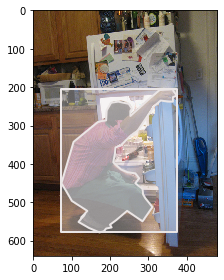

In [ ]:
####################################################
# Variables to play with: area range
####################################################
areaRngLowerBound = 6000
areaRngUpperBound = float('inf')
####################################################

person_cat_id = coco.getCatIds(catNms=['person']);   # returns [1]
person_img_ids = coco.getImgIds(catIds=person_cat_id)
print(f"There are {len(person_img_ids)} images with people in them in the \"{datasetName}\" dataset.")

# Get images of all people with an area within the given range
person_area_annotation_ids = coco.getAnnIds(catIds=person_id, areaRng=[areaRngLowerBound, areaRngUpperBound])
person_area_annotations = coco.loadAnns(person_area_annotation_ids)
person_area_img_ids = [ann['image_id'] for ann in np.array(person_area_annotations)]
print(f"There are {len(person_annotation_ids)} people within the specified area range.")

# Example: display the first person in the list with their annotations
# Note: we can display each labelled pixel or the bounding box
print("\nHere is one of them with the pixel segmentation and bounding box displayed:")
first_person_annotations = person_area_annotations[0]
first_person_img_id = first_person_annotations['image_id']
first_person_img = coco.loadImgs(first_person_img_id)[0]
io.imshow(io.imread(first_person_img['coco_url']))
coco.showAnns([first_person_annotations], draw_bbox=True)

In [ ]:
####################################################
# Example of loading an image from the URL [COMMENTED]
####################################################
# np.random.seed(1)   # for debugging purposes
# catIds = coco.getCatIds(catNms=['person']);
# imgIds = coco.getImgIds(catIds=catIds );

# # Load image with URL (using io)
# img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
# person_rand_img = io.imread(img['coco_url'])
# io.imshow(person_rand_img)

# # NOTE: Can also use matplotlib
# # plt.axis('off')
# # plt.imshow(person_rand_img)
# # plt.show()


#Resize and Convert to Greyscale

In [ ]:
from skimage.color import rgb2gray
from skimage.transform import resize

(96, 96)

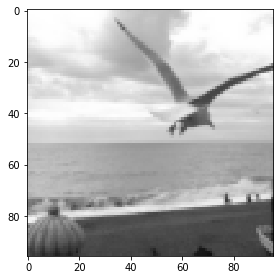

In [ ]:
grey96 = rgb2gray(resize(person_rand_img, (96,96)))
io.imshow(grey96)
np.array(grey96).shape